In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 150

In [2]:
import corner
import emcee3
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from astropy.stats import LombScargle

In [3]:
import celerite
from celerite import terms

from cerotate.k2 import get_light_curve
from cerotate.rotation_term import RotationTerm, MixtureTerm

In [16]:
# t, flux = get_light_curve(1, 201127270)  # failure
# t, flux = get_light_curve(4, 210332154)  # no period
# sections, t, flux = get_light_curve(4, 210771656)  # failure, kink in light curve

# t, flux = get_light_curve(1, 201253025)

sections, t, flux = get_light_curve(1, 201497682)
# sections, t, flux = get_light_curve(2, 205117205)  # rotation
# t, flux = get_light_curve(3, 205943030)
# t, flux = get_light_curve(7, 219128753)
# sections, t, flux = get_light_curve(8, 220684009)
# t, flux = get_light_curve(2, 205625849)  # good rrl
# t, flux = get_light_curve(3, 206105536)  # Another good rrl
# sections, t, flux = get_light_curve(2, 205164324)  # Another good rrl
# sections, t, flux = get_light_curve(3, 206278951)  # Less obvious rrl
# t, flux = get_light_curve(2, 203630276)  # good rrl
# sections, t, flux = get_light_curve(3, 206126731)

In [17]:
# np.savetxt("lc.dat", np.array((t - t.min(), flux, np.ones_like(flux))).T)

In [18]:
# data = np.loadtxt("dfm_lcout.txt")
# t = data[:, 0]
# flux = data[:, 3] + 0.02 * np.random.randn(len(t))
# print(flux)
# flux = (flux / np.median(flux) - 1.0)*100

11.4247188957


/Users/dfm/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


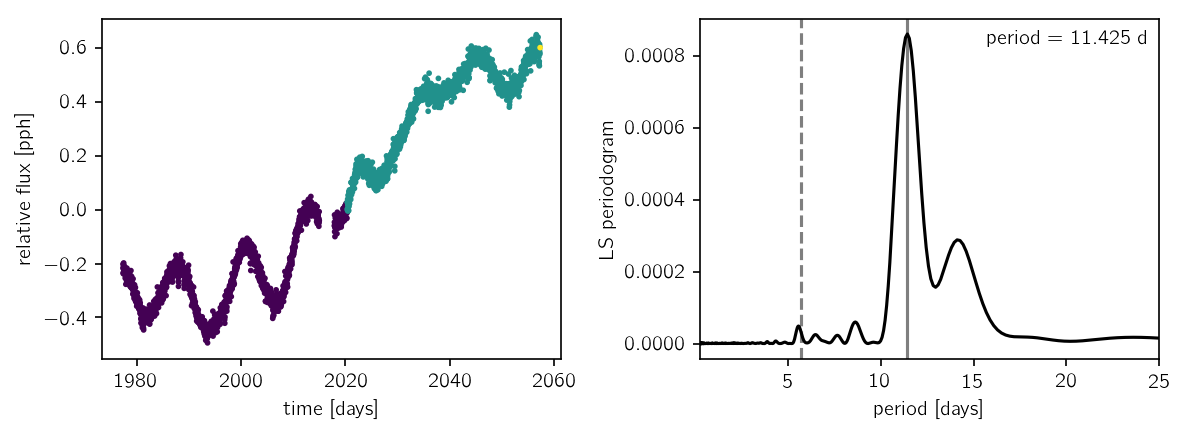

In [19]:
flux0 = np.array(flux) - np.mean(flux)
A = np.vander(t - np.mean(flux), 4)
w = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, flux))
trend = np.dot(A, w)

# First guess at the period
min_period, max_period = 0.25, 25.0

freq = np.linspace(1.0 / max_period, 1.0 / min_period, 5000)
model = LombScargle(t, flux - trend)
power = model.power(freq, method="fast", normalization="psd")
power /= len(t)

# Filter
freq0 = 1.0 / 10.0
filt = 1.0 / np.sqrt(1 + (freq0 / freq) ** (2*3))
power *= filt

period = 1.0 / freq[np.argmax(power)]
print(period)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].scatter(t, flux, c=sections, s=3)
axes[0].set_ylabel("relative flux [pph]")
axes[0].set_xlabel("time [days]")

axes[1].plot(1.0 / freq, power, "k")
axes[1].axvline(period, color="k", alpha=0.5)
axes[1].axvline(0.5 * period, color="k", ls="dashed", alpha=0.5)
axes[1].set_xlabel("period [days]")
axes[1].set_ylabel("LS periodogram")
axes[1].annotate("period = {0:.3f} d".format(period), xy=(1, 1), xycoords="axes fraction",
                 ha="right", va="top", xytext=(-5, -5), textcoords="offset points")

axes[1].set_xlim(min_period, max_period)

fig.set_tight_layout(True)

In [20]:
log_var = np.log(np.var(flux))
# kernel = RotationTerm(
#     log_a=log_var,
#     log_b=-0.1,
#     log_f=-5.0,
#     log_P=np.log(period),
#     bounds=dict(
#         log_a=(-15.0, 15.0),
#         log_b=(-5.0, 5.0),
#         log_f=(-5.0, 5.0),
#         log_P=(np.log(min_period), np.log(max_period)),
#     ),
# )

kernel = MixtureTerm(
    log_a1=log_var,
    log_b1=-0.1,
    log_f1=-5.0,
    log_P=np.log(period),
    mix_par=-1.0,
    log_b2=-0.1,
    log_f2=-5.0,
    bounds=dict(
        log_a1=(-10.0, 10.0),
        log_b1=(-5.0, 5.0),
        log_f1=(-5.0, 5.0),
        log_P=(np.log(min_period), np.log(max_period)),
        mix_par=(-5.0, 5.0),
        log_b2=(-5.0, 5.0),
        log_f2=(-5.0, 5.0),
    ),
)

kernel += terms.SHOTerm(
    log_S0=log_var,
    log_Q=-0.5*np.log(2),
    log_omega0=np.log(2*np.pi/10.0),
    bounds=dict(
        log_S0=(-20.0, 20.0),
        log_omega0=(np.log(2*np.pi/80.0), np.log(2*np.pi/2.0))
    )
)
kernel.terms[1].freeze_parameter("log_Q")

kernel += terms.JitterTerm(log_sigma=np.log(np.median(np.abs(np.diff(flux)))),
                           bounds=[(-10.0, 10.0)])
gp = celerite.GP(kernel)
gp.compute(t)

In [21]:
import numpy as np
from scipy.linalg import cho_factor, cho_solve

from celerite import modeling


class PolynomialModel(modeling.ModelSet):

    def __init__(self, gp, sections, t, y, order=3):
        self.t = t
        self.y = y
        
        A = np.vander((t - np.mean(t)) / (np.max(t) - np.min(t)), order)
        sections = np.atleast_1d(sections)
        s = np.unique(sections)
        self.A = np.zeros((len(t), order*len(s)))
        for i in s:
            m = sections == i
            self.A[m, order*i:order*i+order] = A[m]
        
        self.AT = self.A.T
        super(PolynomialModel, self).__init__([("gp", gp)])

    def get_weights(self):
        gp = self.models["gp"]
        gp.compute(self.t)
        alpha = gp.apply_inverse(self.y)[:, 0]
        KinvA = gp.apply_inverse(self.A)
        S = np.dot(self.AT, KinvA)
        factor = cho_factor(S, overwrite_a=True, check_finite=False)
        ATalpha = np.dot(self.AT, alpha)
        return cho_solve(factor, ATalpha, overwrite_b=True, check_finite=False)

    def alpha(self):
        gp = self.models["gp"]
        gp.compute(self.t)
        alpha = gp.apply_inverse(self.y)[:, 0]
        KinvA = gp.apply_inverse(self.A)
        S = np.dot(self.AT, KinvA)

        factor = cho_factor(S, overwrite_a=True, check_finite=False)
        half_log_det = 0.5 * gp.solver.log_determinant()
        half_log_det += np.sum(np.log(np.diag(factor[0])))

        ATalpha = np.dot(self.AT, alpha)
        term2 = np.dot(KinvA, cho_solve(factor, ATalpha,
                                        check_finite=False, overwrite_b=True))

        half_log_det = 0.5 * gp.solver.log_determinant()
        half_log_det += np.sum(np.log(np.diag(factor[0])))

        return alpha - term2, half_log_det

    def log_marginalized_likelihood(self):
        try:
            alpha, half_log_det = self.alpha()
        except (celerite.solver.LinAlgError, np.linalg.LinAlgError):
            return -np.inf
        return -0.5*np.dot(self.y, alpha) - half_log_det

    def get_trend(self):
        w = self.get_weights()
        return np.dot(self.A, w)

In [22]:
model = PolynomialModel(gp, sections, t, flux)
model.log_marginalized_likelihood()

def nll(params):
    model.set_parameter_vector(params)
    try:
        return -model.log_marginalized_likelihood()
    except celerite.solver.LinAlgError:
        return 1e10
    
gp.freeze_parameter("kernel:terms[0]:log_P")
p0 = gp.get_parameter_vector()
log_P0 = gp.get_parameter("kernel:terms[0]:log_P")
best = (np.inf, p0)
for log_period in log_P0 + np.log([0.5, 1.0, 2.0]):
    if not np.allclose(log_period, log_P0) and not (2*min_period < np.exp(log_period) < max_period):
        continue
    gp.set_parameter("kernel:terms[0]:log_P", log_period)
    gp.freeze_parameter("kernel:terms[0]:log_P")
    bounds = gp.get_parameter_bounds()
    soln = minimize(nll, p0, method="L-BFGS-B", bounds=bounds)
    gp.set_parameter_vector(soln.x)

    gp.thaw_parameter("kernel:terms[0]:log_P")
    bounds = gp.get_parameter_bounds()
    soln = minimize(nll, gp.get_parameter_vector(), method="L-BFGS-B", bounds=bounds)
    gp.set_parameter_vector(soln.x)
    
    print(np.exp(gp.get_parameter("kernel:terms[0]:log_P")), soln.fun, soln.success)
    if soln.fun < best[0]:
        best = soln.fun, soln.x

gp.set_parameter_vector(best[1])

flux = flux0 - model.get_trend()

5.71235944785 inf False
11.4247188957 inf False
22.8494377914 inf False


ValueError: NumPy boolean array indexing assignment cannot assign 9 input values to the 10 output values where the mask is true

11.3171891147 -12537.350703459479 True
22.8860065614 -12535.612858895129 True


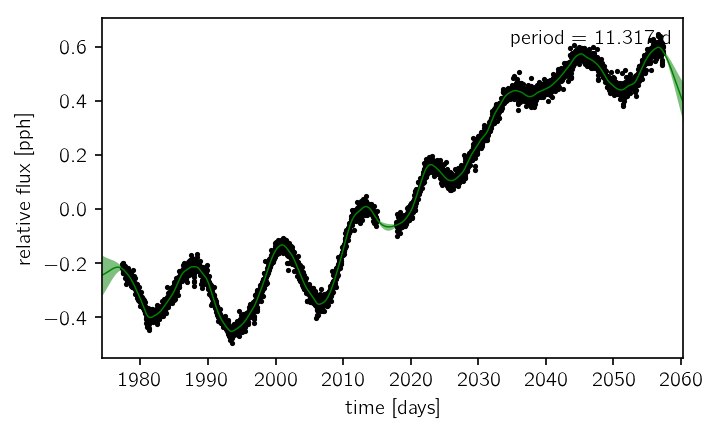

In [23]:
def nll(params):
    gp.set_parameter_vector(params)
    try:
        grad = gp.grad_log_likelihood(flux)
    except celerite.solver.LinAlgError:
        return 1e10, np.zeros_like(params)
    return -grad[0], -grad[1]

gp.freeze_parameter("kernel:terms[0]:log_P")
p0 = gp.get_parameter_vector()
log_P0 = gp.get_parameter("kernel:terms[0]:log_P")
best = (np.inf, p0)
for log_period in log_P0 + np.log([0.5, 1.0, 2.0]):
    if not np.allclose(log_period, log_P0) and not (2*min_period < np.exp(log_period) < max_period):
        continue
    gp.set_parameter("kernel:terms[0]:log_P", log_period)
    gp.freeze_parameter("kernel:terms[0]:log_P")
    bounds = gp.get_parameter_bounds()
    soln = minimize(nll, p0, jac=True, method="L-BFGS-B", bounds=bounds)
    gp.set_parameter_vector(soln.x)

    gp.thaw_parameter("kernel:terms[0]:log_P")
    bounds = gp.get_parameter_bounds()
    soln = minimize(nll, gp.get_parameter_vector(), jac=True, method="L-BFGS-B", bounds=bounds)
    gp.set_parameter_vector(soln.x)
    
    print(np.exp(gp.get_parameter("kernel:terms[0]:log_P")), soln.fun, soln.success)
    if soln.fun < best[0]:
        best = soln.fun, soln.x

gp.set_parameter_vector(best[1])

# # Remove a polynomial
# A = np.vander(t - np.mean(t), 4)
# A[:, :-1] /= np.std(A[:, :-1], axis=0)
# w = np.linalg.solve(np.dot(A.T, gp.apply_inverse(A)), np.dot(A.T, gp.apply_inverse(flux)))
# flux = flux0 - np.dot(A, w).flatten()

# p0 = gp.get_parameter_vector()
# soln = minimize(nll, p0, jac=True, method="L-BFGS-B", bounds=bounds)
# gp.set_parameter_vector(soln.x)
# print(np.exp(gp.get_parameter("kernel:terms[0]:log_P")), soln.fun)

x = np.linspace(t.min() - 3, t.max() + 3, 5000)
pred_mu, pred_var = gp.predict(flux, x, return_var=True)
pred_sig = np.sqrt(pred_var)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(t, flux, ".k", ms=3)
ax.plot(x, pred_mu, "g", lw=0.7)
ax.fill_between(x, pred_mu+pred_sig, pred_mu-pred_sig, color="g",
                alpha=0.5, lw=0)
ax.set_ylabel("relative flux [pph]")
ax.set_xlabel("time [days]")
ax.set_xlim(x.min(), x.max())

ml_period = np.exp(gp.kernel.terms[0].log_P)
ax.annotate("period = {0:.3f} d".format(ml_period),
            xy=(1, 1), xycoords="axes fraction",
            ha="right", va="top", xytext=(-5, -5), textcoords="offset points")

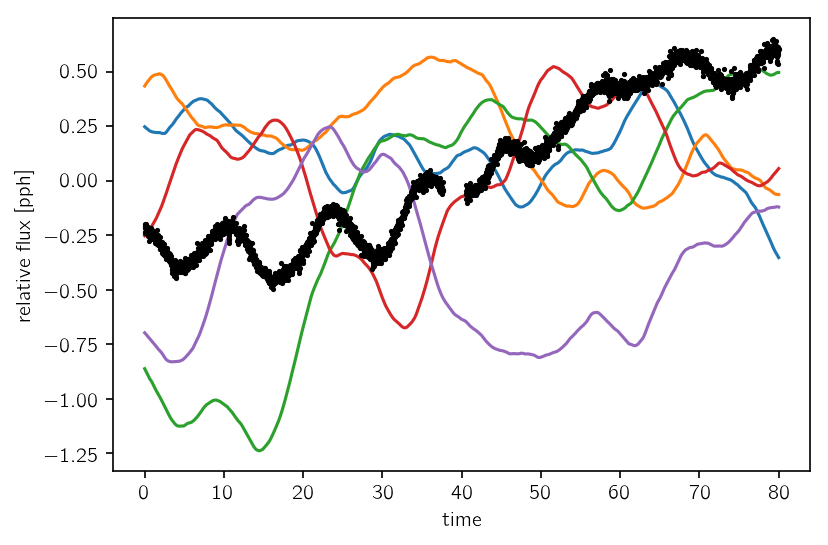

In [33]:
gp2 = celerite.GP(terms.TermSum(*(kernel.terms[:-1])))
x = np.linspace(0, 80, 1500)
gp2.compute(x)
y = gp2.sample(size=5)
plt.plot(x, y.T)
plt.plot(t - t.min(), flux, ".k", ms=3)
plt.xlabel("time")
plt.ylabel("relative flux [pph]")
plt.savefig("sims.png")

In [87]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_a1', 3.7888017959259526),
             ('kernel:terms[0]:log_b1', 1.3565332049669343),
             ('kernel:terms[0]:log_f1', -5.0),
             ('kernel:terms[0]:log_P', -0.64212233730619961),
             ('kernel:terms[0]:mix_par', 1.5041365517258773),
             ('kernel:terms[0]:log_b2', 1.6206900482849582),
             ('kernel:terms[0]:log_f2', -5.0),
             ('kernel:terms[1]:log_S0', 3.5286389473852302),
             ('kernel:terms[1]:log_omega0', -0.35765072560110206),
             ('kernel:terms[2]:log_sigma', 2.1999533304978813)])

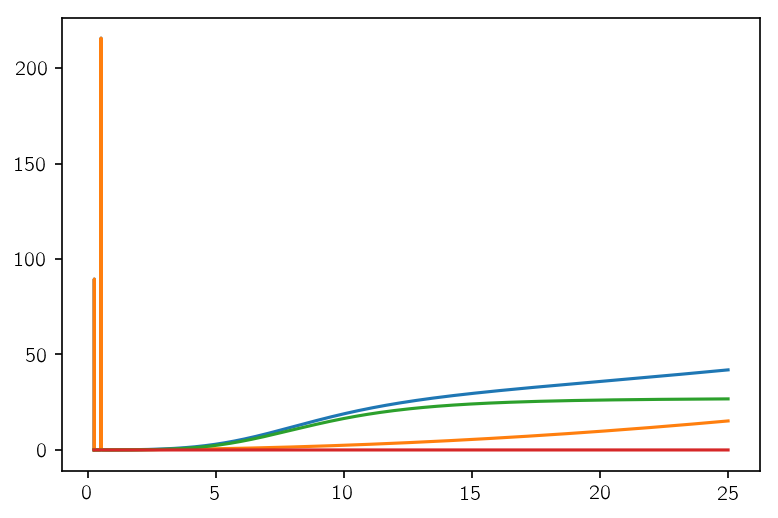

In [88]:
omega = 2 * np.pi * freq
plt.plot(1./freq, gp.kernel.get_psd(omega))
for term in gp.kernel.terms:
    plt.plot(1./freq, term.get_psd(omega))

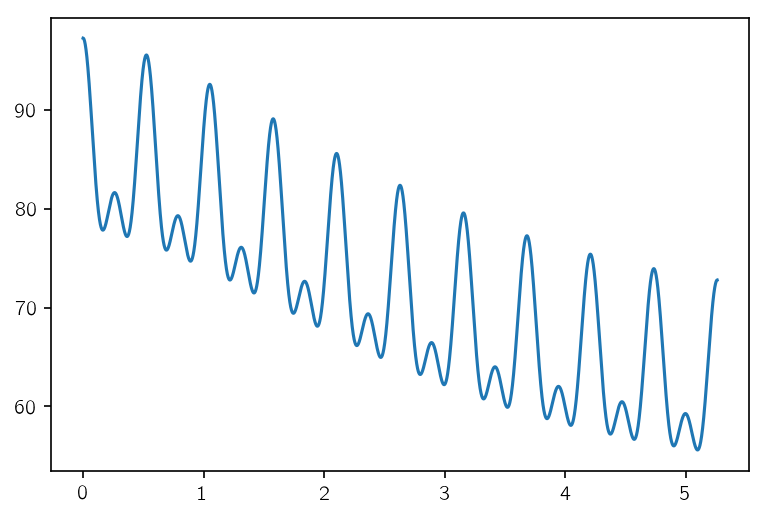

In [89]:
dt = np.linspace(0, period*10, 5000)
plt.plot(dt, gp.kernel.get_value(dt))
# for term in gp.kernel.terms:
#     plt.plot(dt, term.get_value(dt))

In [90]:
def log_prob(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    try:
        return lp + gp.log_likelihood(flux)
    except celerite.solver.LinAlgError:
        return -np.inf

ndim = len(best[1])
nwalkers = 64
pos = best[1] + 1e-5 * np.random.randn(nwalkers, ndim)
lp = np.array(list(map(log_prob, pos)))
m = ~np.isfinite(lp)
while np.any(m):
    pos[m] = best[1] + 1e-5 * np.random.randn(m.sum(), ndim)
    lp[m] = np.array(list(map(log_prob, pos[m])))
    m = ~np.isfinite(lp)
    
sampler = emcee3.Sampler([
    emcee3.moves.StretchMove(),
    emcee3.moves.DEMove(1e-3),
    emcee3.moves.KDEMove(),
])  #, backend=emcee3.backends.HDFBackend("astero-{0}.h5".format(epicid)))

with emcee3.pools.InterruptiblePool() as pool:
    ensemble = emcee3.Ensemble(emcee3.SimpleModel(log_prob), pos,
                               pool=pool)
    ensemble = sampler.run(ensemble, 5000, progress=True)

100%|██████████| 5000/5000 [04:11<00:00, 20.12it/s]


Final c is 2


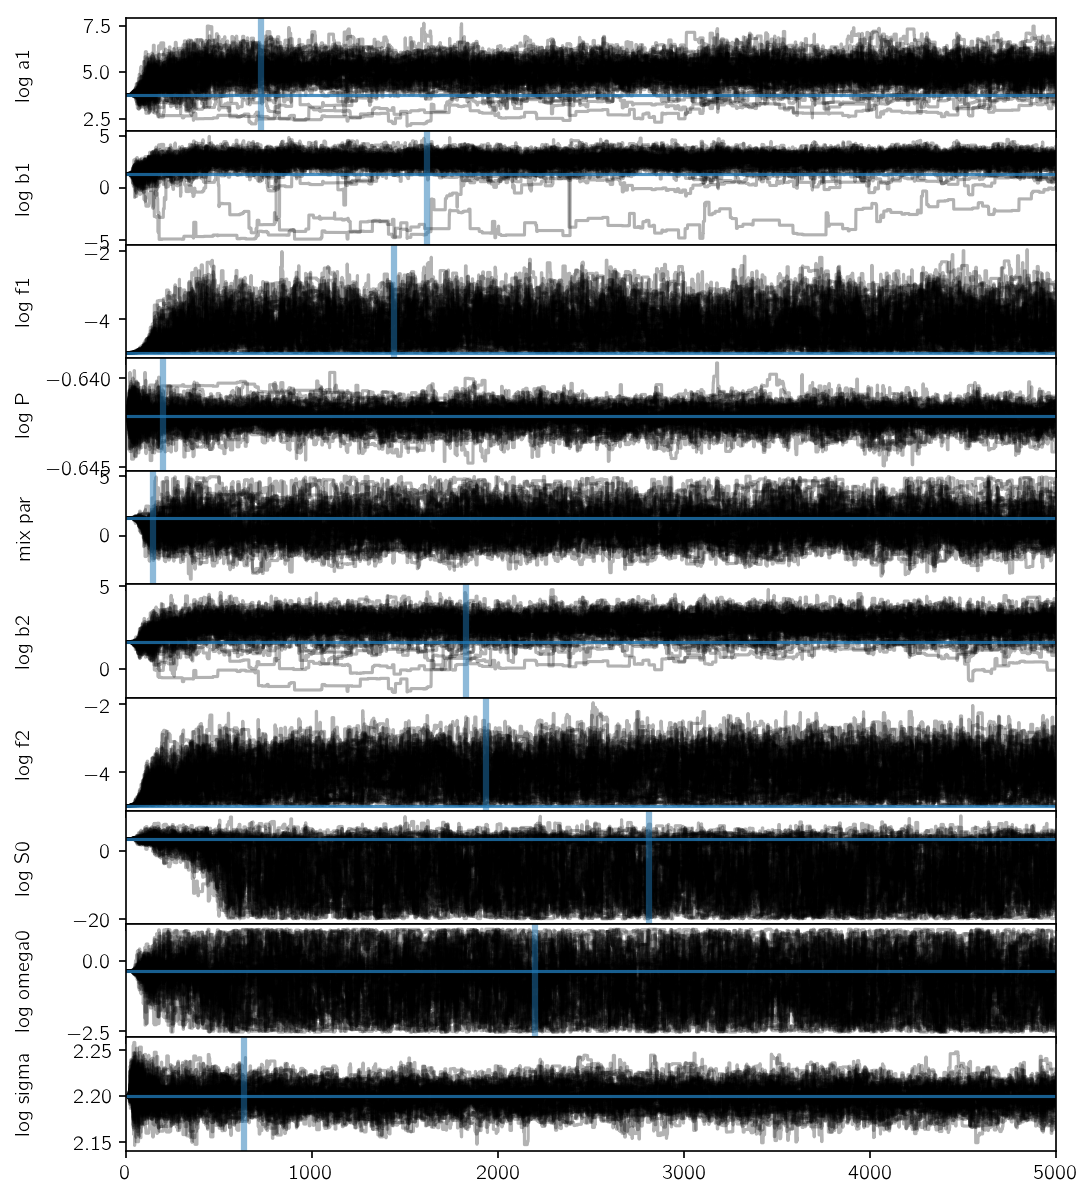

In [91]:
chain = sampler.get_coords()
names = gp.get_parameter_names()
names = [n.split(":")[-1].replace("_", " ") for n in names]
ndim = chain.shape[-1]

tau = 100 * np.ones(ndim)
for c in range(5, 0, -1):
    try:
        tau = sampler.get_integrated_autocorr_time(c=c)
    except emcee3.autocorr.AutocorrError:
        continue
    print("Final c is {0}".format(c))
    break
    
samples = sampler.get_coords(flat=True, discard=int(tau[3]*5))
logprob_chain = sampler.get_log_probability(flat=True, discard=int(tau[3]*5))

fig, axes = plt.subplots(ndim, 1, figsize=(8, ndim*1), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(chain[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(chain))
    ax.set_ylabel(names[i])
    ax.axvline(5*tau[i], alpha=0.5, lw=3)
    ax.axhline(best[1][i], alpha=0.8)
    ax.yaxis.set_label_coords(-0.1, 0.5)

fig.subplots_adjust(hspace=0)

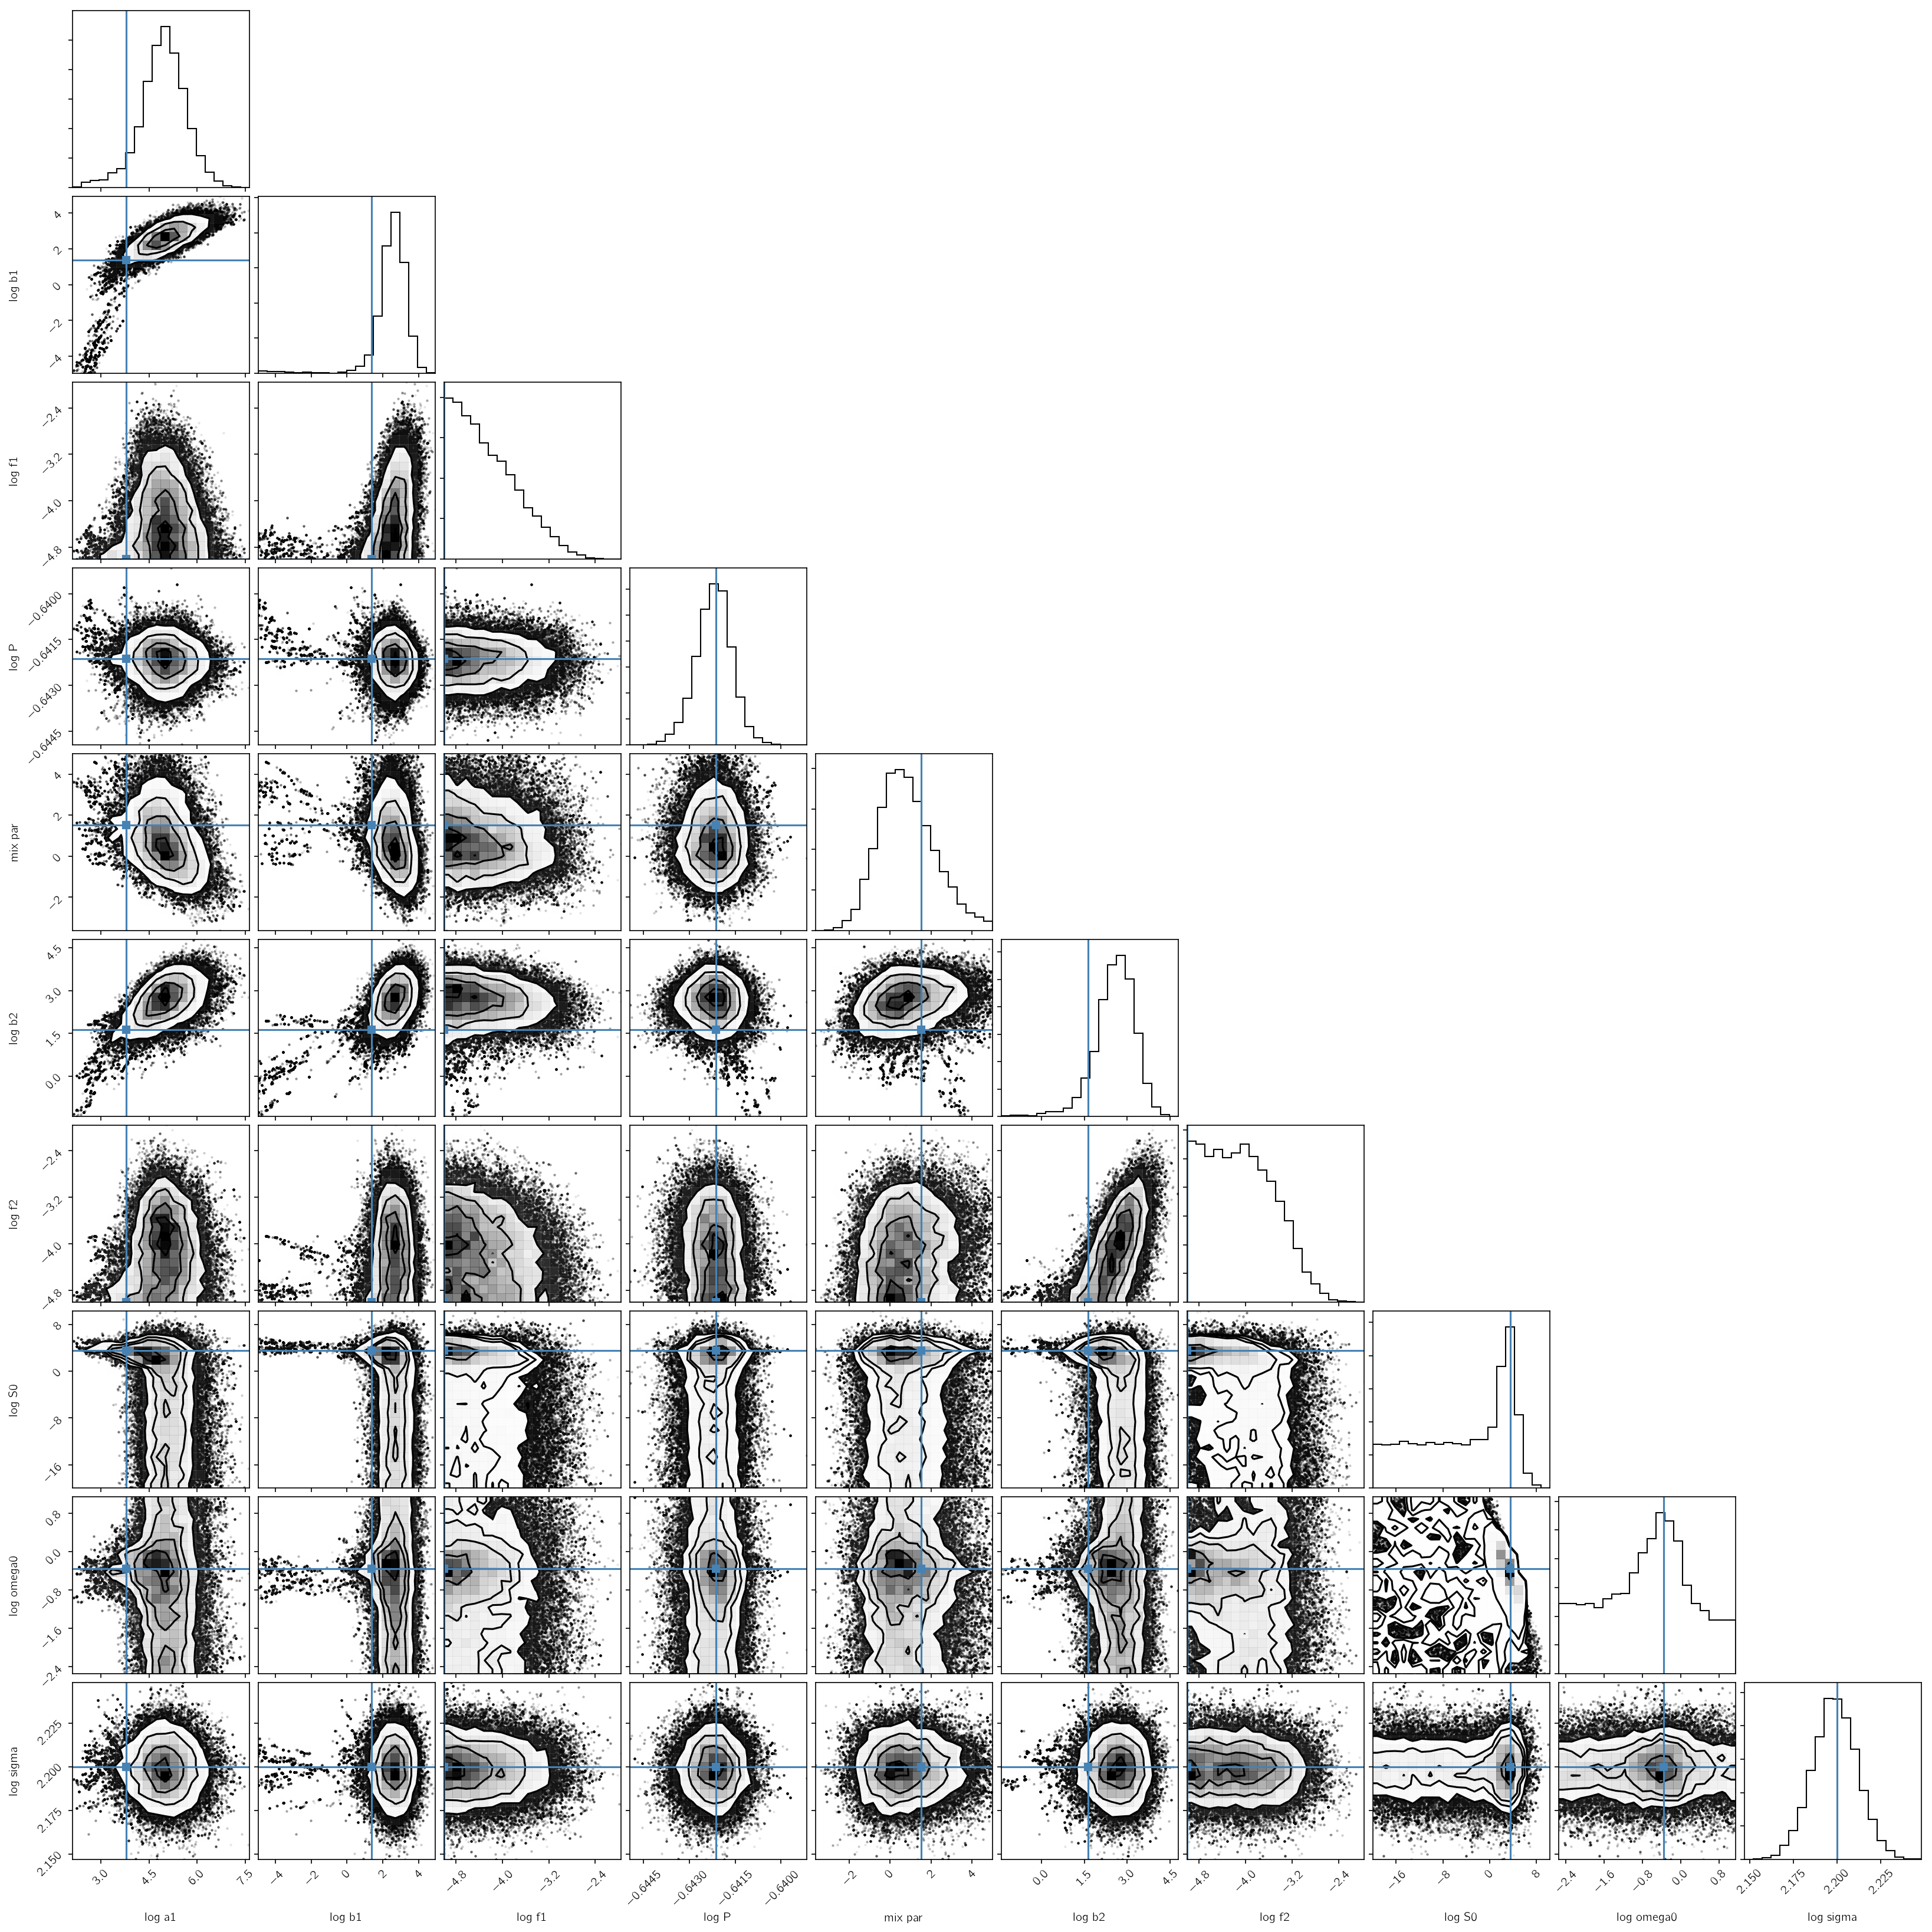

In [92]:
corner.corner(samples, truths=best[1], labels=names);

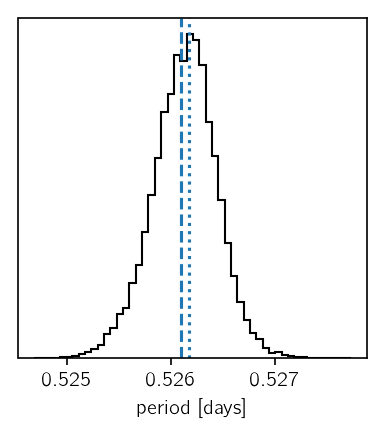

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

ax.hist(np.exp(samples[:, 3]), 50, color="k", histtype="step")
ax.axvline(period, ls="--")
ax.axvline(ml_period, ls=":")
ax.set_yticks([])
ax.set_xlabel("period [days]");

0.526037697928


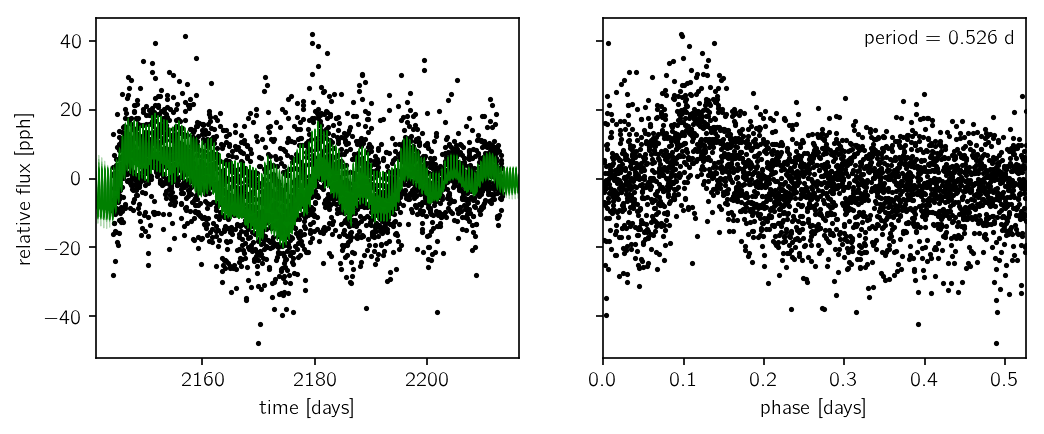

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

map_sample = samples[np.argmax(logprob_chain)]
map_period = np.exp(map_sample[3])
print(map_period)

ax1.plot(t, flux, ".k", ms=3)
ax2.plot(t % map_period, flux, ".k", ms=3)

for s in samples[np.random.randint(len(samples), size=25)]:
    gp.set_parameter_vector(s)
    ax1.plot(x, gp.predict(flux, x, return_cov=False), "g", alpha=0.3, lw=0.5)

ax2.annotate("period = {0:.3f} d".format(map_period),
             xy=(1, 1), xycoords="axes fraction",
             ha="right", va="top", xytext=(-5, -5), textcoords="offset points");
    
ax1.set_ylabel("relative flux [pph]")
ax1.set_xlabel("time [days]")
ax1.set_xlim(x.min(), x.max())
ax2.set_xlabel("phase [days]")
ax2.set_xlim(0, map_period);

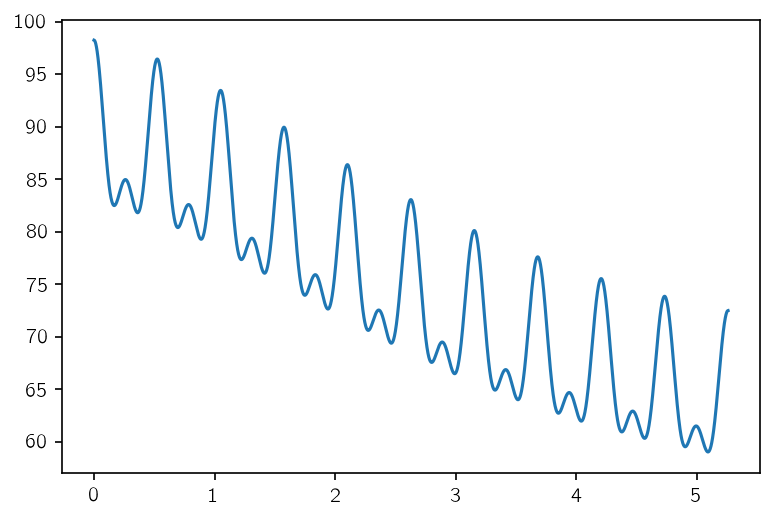

In [95]:
dt = np.linspace(0, map_period*10, 5000)
gp.set_parameter_vector(map_sample)
plt.plot(dt, gp.kernel.get_value(dt))
# for term in gp.kernel.terms:
#     plt.plot(dt, term.get_value(dt))